In [79]:
# Ignoring warnings.
import warnings

warnings.filterwarnings('ignore')
# Imports, as always...

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

# PyTorch (+ Geometric)
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv

# Visualisation.
import matplotlib.pyplot as plt
import seaborn as sns

# Script imports.
from scripts.training import train, evaluate
from scripts.utils import produce_reduced_embeddings, plot_reduced_embeddings
from scripts import models

# Beautification.
sns.set_context('paper')
sns.set_style('dark')
sns.set_palette('Set2')

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set RNG.
torch.manual_seed(42)

# Dataset.
from torch_geometric.datasets import Planetoid

dataset = Planetoid(
    root='./',
    name='CiteSeer',
    split='public',
    transform=torch_geometric.transforms.GCNNorm()
).to(device)

print(dataset.data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


# Convergence

This notebook explores the convergence property of GNN architectures with differing residual connection methods, as trained in `training.ipynb` and defined in `./scripts/`.

## Loading Trained Models

In [2]:
# Settings shared across all models.
n_nodes = dataset.data.x.size(0)
model_depths = [1, 5, 10, 20]
aggregation_function = GCNConv
hid_dim = 64
dropout_ratio = .1
act_fn = F.relu

In [3]:
# Instantiating models of the correct architectural designs.
def instantiate_models():
    none_models = [
        models.BackboneModel(
            residual_method=None,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ] 
    fixed_models = [
        models.BackboneModel(
            residual_method=lambda *args: models.FixedRC(torch.ones(n_nodes)/2, *args),
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ]
    free_models = [
        models.BackboneModel(
            residual_method=models.FreeRC,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ]
    hierarchical_models = [
        models.BackboneModel(
            residual_method=models.HierarchicalRC,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in model_depths
    ]
    cluster_models = [
        models.BackboneModel(
            residual_method=models.ClusterKeepingRC,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn,
            L_0=2 # Give an extra layer before cluster keeping.
        ).to(device)
        for depth in model_depths
    ]
    
    return none_models, fixed_models, free_models, hierarchical_models, cluster_models

none_models, fixed_models, free_models, hierarchical_models, cluster_models = instantiate_models()

In [4]:
def load_state_dicts():
    for model in none_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/none_{depth}.pt'))   
        
    # Too big to push to repo.
    for model in fixed_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/fixed_{depth}.pt'))   
        
    # Too big to push to repo.
    for model in free_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/free_{depth}.pt'))   
    
    # Too big to push to repo.
    for model in hierarchical_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/hierarchical_{depth}.pt'))   
        
    for model in cluster_models:
        depth = model.n_layers
        model.load_state_dict(torch.load(f'./models/gcn/cluster_{depth}.pt'))   
        
# Takes ~16s

load_state_dicts()

## Master Convergence Plot

In [5]:
# Generate the reduced features for each model at each depth (takes ~18s).
none_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in none_models
}
fixed_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in fixed_models
}
free_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in free_models
}
hierarchical_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in hierarchical_models
}
cluster_reduced_features_by_depth = {
    model.n_layers: produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in cluster_models
}

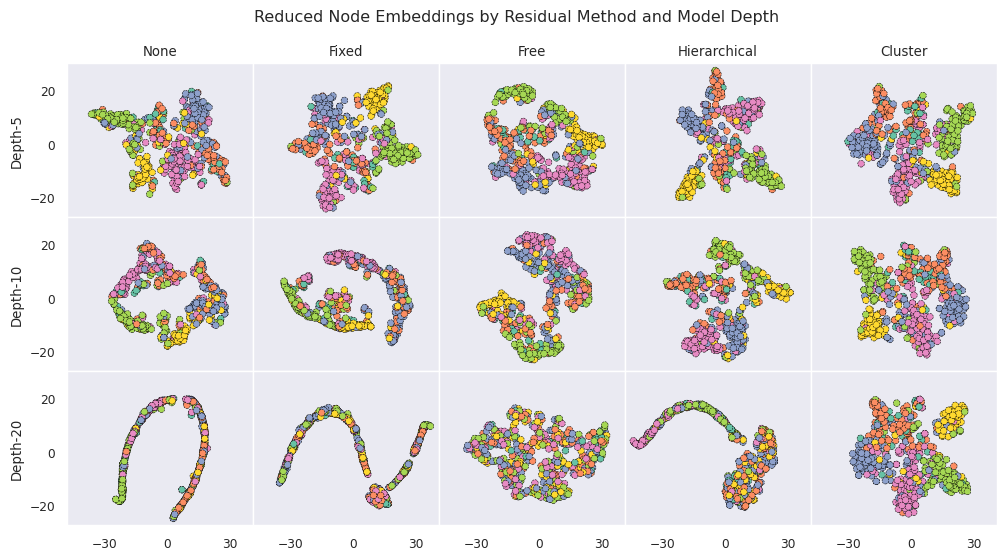

In [6]:
def draw_scatterplot(feature_df, ax):
    return sns.scatterplot(
        # Plot points and colour them.
        x=feature_df['dimension 1'],
        y=feature_df['dimension 2'],
        hue=feature_df['labels'],
        ax=ax,

        # Beautification.
        palette='Set2',
        linestyle='--',
        edgecolors='k'
    )

def draw_master_convergence_plot(save=True):
    # Put all subplots on the same axes scales.
    fig, axes = plt.subplots(3, 5, figsize=(12, 6), sharex='all', sharey='all')
    
    for row, depth in enumerate(model_depths[1:]):
        draw_scatterplot(none_reduced_features_by_depth[depth], axes[row][0])
        draw_scatterplot(fixed_reduced_features_by_depth[depth], axes[row][1])
        draw_scatterplot(free_reduced_features_by_depth[depth], axes[row][2])
        draw_scatterplot(hierarchical_reduced_features_by_depth[depth], axes[row][3])
        draw_scatterplot(cluster_reduced_features_by_depth[depth], axes[row][4])
        
    # Remove clutter.
    [[axes[i][j].legend([], [], frameon=False) for i in range(3)] for j in range(5)]
    [[axes[i][j].set_xlabel('') for i in range(3)] for j in range(5)]
    [[axes[i][j].set_xticks([-30, 0, 30]) for i in range(3)] for j in range(5)]
    [[axes[i][j].set_ylabel('') for i in range(3)] for j in range(5)]
    [[axes[i][j].set_yticks([-20, 0, 20]) for i in range(3)] for j in range(5)]
    
    # Add titles.
    [axes[0][i].set_title(['None', 'Fixed', 'Free', 'Hierarchical', 'Cluster'][i]) for i in range(5)]
    [axes[i][0].set_ylabel(f'Depth-{model_depths[i+1]}') for i in range(3)]
    
    fig.suptitle('Reduced Node Embeddings by Residual Method and Model Depth', y=.97)
        
    # Save figure.
    plt.subplots_adjust(wspace=0, hspace=0)
    if save:
        plt.savefig('./figures/convergence/master.pdf', bbox_inches='tight')
    
draw_master_convergence_plot(False)

## Quantifying Convergence

We would like a nice numerical method to quantify how "converged" a graph has become. Intuitively, this method will be a function of the *spread of node representations*. There are a boat-load of metrics to choose from that do this:
- **Variance**, straight-forwardly measuring the variance of node representations around a centroid (i.e. graph-level representation);
- **Cosine similarity**, measuring the alignment of node representations;
- **Euclidean distance**, measuring the distance between nodes in the representation space; etc.

Spectral analysis may provide the most powerful way to measure convergence of nodes in the representation space. Again, there are different ways to do this.

In [76]:
def produce_embeddings(model: torch.nn.Module, data: torch_geometric.data.data.Data, mask: torch.Tensor) -> np.ndarray:
    # Into evaluation mode.
    model.eval()

    # Generate node embeddings (as a numpy array).
    embeddings = model.generate_node_embeddings(data.x, data.edge_index)[mask]
    return embeddings.detach().cpu().numpy()

def compute_svd_entropy(embeddings: np.ndarray) -> float:
    # SVD.
    singular_values = np.linalg.svd(embeddings).S
    
    # Normalise and compute entropy.
    normalised_singular_values = singular_values / sum(singular_values)
    return - sum(normalised_singular_values * np.log(normalised_singular_values))

def compute_svd_contributions(embeddings: np.ndarray, n_values: int) -> float:
    # SVD.
    singular_values = np.linalg.svd(embeddings).S
    
    # Normalise and compute contributions.
    normalised_singular_values = singular_values / sum(singular_values)
    return sum(normalised_singular_values[:n_values])

def compute_distances_from_centroid(embeddings: np.ndarray, dist_method : str = 'Euclidean') -> np.ndarray:
    # Pool (e.g. mean pooling) to compute a graph-level representation (i.e. a centroid).
    centroid = np.mean(embeddings, axis=0)
    
    # Specify the distance method.
    def dist_fn(x, y):
        if dist_method == 'Cosine':
            return 1 - (np.dot(x, y) / np.linalg.norm(x) * np.linalg.norm(y))
        
        return np.linalg.norm(x - y)

    # For every datapoint, compute the "distance" to centroid.
    return np.apply_along_axis(lambda x: dist_fn(x, centroid), 1, embeddings)

def compute_mean_spread(embeddings: np.ndarray, dist_method : str = 'Euclidean') -> float:
    distances = compute_distances_from_centroid(embeddings, dist_method)
    return distances.mean()

def compute_std_spread(embeddings: np.ndarray, dist_method : str = 'Euclidean') -> float:
    distances = compute_distances_from_centroid(embeddings, dist_method)
    return distances.std()

In [91]:
def get_stats(gnn_dict, *stat_tuples) -> pd.DataFrame:
    stats_df = pd.DataFrame(columns=['Model', 'Depth'] + [stat[1] for stat in stat_tuples])
    
    for model_title, model_list in gnn_dict.items():
        for model in model_list:
            embeddings = produce_embeddings(model, dataset.data, dataset.data.val_mask)
            
            row = {'Model': model_title, 'Depth': model.n_layers}
            for stat_fn, stat_title in stat_tuples:
                row[stat_title] = stat_fn(embeddings)
                
            stats_df = pd.concat([stats_df, pd.DataFrame([row])], ignore_index=True)
    
    return stats_df.reset_index().drop(columns=['index'])
        
gnn_dict = {'None': none_models, 'Fixed': fixed_models, 'Free': free_models, 'Hierarchical': hierarchical_models, 'Cluster': cluster_models}
        
get_stats(
    gnn_dict,
    (compute_svd_entropy, 'SVD Entropy'), 
    (lambda xs: compute_svd_contributions(xs, 3), 'SVD Contributions (3)'),
    (compute_mean_spread, 'Mean Dist. to Centroid'),
    (compute_std_spread, 'Std. Dist. to Centroid')    
)

,Model,Depth,SVD Entropy,SVD Contributions (3),Mean Dist. to Centroid,Std. Dist. to Centroid
0,None,1,1.196214,0.826240,1.089105,0.583542
1,None,5,1.400013,0.826559,7.139587,4.862138
2,None,10,1.367863,0.866712,23.137768,17.056652
3,None,20,0.551320,0.986432,7.889025,9.202678
4,Fixed,1,1.199846,0.825662,1.103644,0.598294
5,Fixed,5,1.031000,0.877437,3.505544,1.938580
6,Fixed,10,0.850120,0.956541,7.957354,8.863771
7,Fixed,20,0.007381,0.999938,0.015113,0.018229
8,Free,1,1.203376,0.823757,1.107464,0.585284
9,Free,5,1.231114,0.868760,5.524478,3.285843


### More Detail

In [164]:
def analyse_convergence_by_depth(residual_method, residual_name, depths):
    # Define and load weights.
    gnns = [
        models.BackboneModel(
            residual_method=residual_method,
            aggregation_function=aggregation_function,
            n_nodes=n_nodes,
            input_dim=dataset.num_features,
            hid_dim=hid_dim,
            n_classes=dataset.num_classes,
            n_layers=depth,
            dropout_ratio=dropout_ratio,
            act_fn=act_fn
        ).to(device)
        for depth in depths
    ] 
    [gnn.load_state_dict(torch.load(f'./models/gcn/{residual_name.lower()}_{gnn.n_layers}.pt')) for gnn in gnns]
        
    # Get convergence stats.
    convergence_stats = get_stats(
        {residual_name: gnns},
        (compute_svd_entropy, 'SVD Entropy'), 
        (lambda xs: compute_svd_contributions(xs, 3), 'SVD Contributions (3)')
    )
    
    return convergence_stats

In [165]:
none_convergence_stats = analyse_convergence_by_depth(
    residual_method=None,
    residual_name='None',
    depths=range(1, 21)
)

In [168]:
fixed_convergence_stats = analyse_convergence_by_depth(
    residual_method=lambda *args: models.FixedRC(torch.ones(n_nodes)/2, *args),
    residual_name='Fixed',
    depths=range(1, 21)
)

In [169]:
free_convergence_stats = analyse_convergence_by_depth(
    residual_method=models.FreeRC,
    residual_name='Free',
    depths=range(1, 21)
)

In [170]:
joined_convergence_stats = pd.concat([none_convergence_stats, fixed_convergence_stats, free_convergence_stats])
joined_convergence_stats

,Model,Depth,SVD Entropy,SVD Contributions (3)
0,None,1,1.200562,0.824937
1,None,2,1.191358,0.847637
2,None,3,1.216395,0.845684
3,None,4,1.269370,0.832313
4,None,5,1.455891,0.814516
5,None,6,1.420168,0.847115
6,None,7,1.490962,0.831287
7,None,8,1.464208,0.830000
8,None,9,1.448428,0.847227
9,None,10,1.423859,0.843783


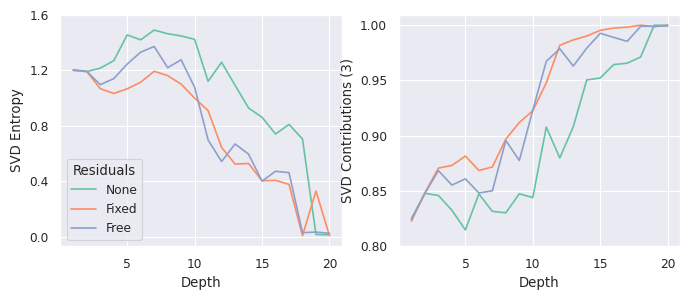

In [171]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all')

sns.lineplot(data=joined_convergence_stats, x='Depth', y='SVD Entropy', hue='Model', ax=axes[0])
sns.lineplot(data=joined_convergence_stats, x='Depth', y='SVD Contributions (3)', hue='Model', ax=axes[1])

axes[0].set_yticks([.0, .4, .8, 1.2, 1.6])
axes[1].set_yticks([.8, .85, .9, .95, 1.])

axes[0].legend(loc='lower left', title='Residuals')
axes[1].legend([], [], frameon=False)

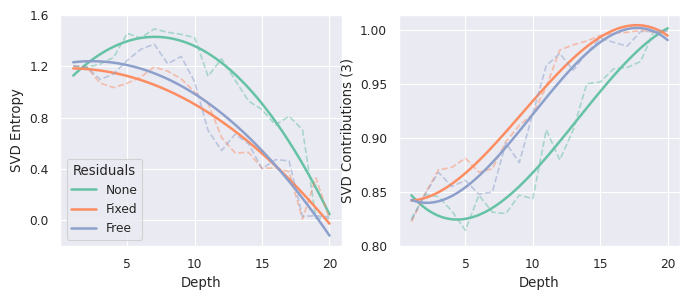

In [172]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex='all')
colours = sns.color_palette('Set2', 3)

# Entropies.
sns.regplot(
    x=none_convergence_stats['Depth'].astype(int), 
    y=none_convergence_stats['SVD Entropy'], 
    order=2,
    color=colours[0], 
    scatter=False,
    ci=None,
    ax=axes[0], label='None'
)
sns.lineplot(
    x=none_convergence_stats['Depth'].astype(int), 
    y=none_convergence_stats['SVD Entropy'], 
    color=colours[0], 
    linestyle='--',
    alpha=.5,
    ax=axes[0]
)
sns.regplot(
    x=fixed_convergence_stats['Depth'].astype(int), 
    y=fixed_convergence_stats['SVD Entropy'], 
    order=2,
    color=colours[1], 
    scatter=False,
    ci=None,
    ax=axes[0], label='Fixed'
)
sns.lineplot(
    x=fixed_convergence_stats['Depth'].astype(int), 
    y=fixed_convergence_stats['SVD Entropy'], 
    color=colours[1], 
    linestyle='--',
    alpha=.5,
    ax=axes[0]
)
sns.regplot(
    x=free_convergence_stats['Depth'].astype(int), 
    y=free_convergence_stats['SVD Entropy'], 
    order=2,
    color=colours[2], 
    scatter=False,
    ci=None,
    ax=axes[0], label='Free'
)
sns.lineplot(
    x=free_convergence_stats['Depth'].astype(int), 
    y=free_convergence_stats['SVD Entropy'], 
    color=colours[2], 
    linestyle='--',
    alpha=.5,
    ax=axes[0]
)

# Contributions.
sns.regplot(
    x=none_convergence_stats['Depth'].astype(int), 
    y=none_convergence_stats['SVD Contributions (3)'], 
    order=3,
    color=colours[0], 
    scatter=False,
    ci=None,
    ax=axes[1], label='None'
)
sns.lineplot(
    x=none_convergence_stats['Depth'].astype(int), 
    y=none_convergence_stats['SVD Contributions (3)'], 
    color=colours[0], 
    linestyle='--',
    alpha=.5,
    ax=axes[1]
)
sns.regplot(
    x=fixed_convergence_stats['Depth'].astype(int), 
    y=fixed_convergence_stats['SVD Contributions (3)'], 
    order=3,
    color=colours[1], 
    scatter=False,
    ci=None,
    ax=axes[1], label='Fixed'
)
sns.lineplot(
    x=fixed_convergence_stats['Depth'].astype(int), 
    y=fixed_convergence_stats['SVD Contributions (3)'], 
    color=colours[1], 
    linestyle='--',
    alpha=.5,
    ax=axes[1]
)
sns.regplot(
    x=free_convergence_stats['Depth'].astype(int), 
    y=free_convergence_stats['SVD Contributions (3)'], 
    order=3,
    color=colours[2], 
    scatter=False,
    ci=None,
    ax=axes[1], label='Free'
)
sns.lineplot(
    x=free_convergence_stats['Depth'].astype(int), 
    y=free_convergence_stats['SVD Contributions (3)'], 
    color=colours[2], 
    linestyle='--',
    alpha=.5,
    ax=axes[1]
)


axes[0].set_yticks([.0, .4, .8, 1.2, 1.6])
axes[1].set_yticks([.8, .85, .9, .95, 1.])

axes[0].legend(loc='lower left', title='Residuals')
axes[1].legend([], [], frameon=False)

SVD is not able to quantify what we can intuitively see to be the case through the reduced embedding visualisations! Clearly, the embedding representations are inherently nonlinear, and so SVD cannot be used. 

We then need a nonlinear method! We can try **Kernel PCA**.

## Quantifying 'Cluster Mixing'